## HR Analytics

Santhosh Babu S

In [22]:
# 1. Imports & configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
plt.rcParams.update({'figure.max_open_warning': 0, 'font.size': 10})
OUT_FOLDER = Path('HR_Analytics_Output')
OUT_FOLDER.mkdir(parents=True, exist_ok=True)

# Color palette (Power BI-like)
COLORS = {
    'accent1':'#7AE0F0','accent2':'#84B4CB','accent3':'#B1E1FE','muted':'#B3B2B3',
    'excellent':'#84B4CB','good':'#7AE0F0','average':'#EFB4B9','poor':'#99A8AF'
}

print('Imports loaded. Output folder:', OUT_FOLDER.resolve())

Imports loaded. Output folder: C:\Users\Santhosh\Downloads\hr project\HR_Analytics_Output


In [23]:
# 2. Load datasets (place Employees.xlsx, Dim_monthly_performance.xlsx, Calender.xlsx next to this notebook)
emp = pd.read_excel('Employees.xlsx')
dim = pd.read_excel('Dim_monthly_performance.xlsx')
cal = pd.read_excel('Calender.xlsx')

# Normalize columns
for df in (emp, dim, cal):
    df.columns = df.columns.str.strip()

print('Loaded: Employees', emp.shape, 'Dim', dim.shape, 'Cal', cal.shape)

Loaded: Employees (7500, 25) Dim (6041, 24) Cal (4744, 16)


In [24]:
# 3. Basic cleaning
# create age group if numeric age column exists
age_col = next((c for c in emp.columns if 'age' in c.lower() and 'group' not in c.lower()), None)
if age_col and 'Age Group' not in emp.columns:
    emp['age_num'] = pd.to_numeric(emp[age_col], errors='coerce')
    bins = [0,20,25,35,45,55,65,100]
    labels = ['0-20','21-25','26-35','36-45','46-55','56-65','65+']
    emp['Age Group'] = pd.cut(emp['age_num'], bins=bins, labels=labels, right=True)

# fill object NA for safe grouping
for c in emp.select_dtypes(include=['object']).columns:
    emp[c] = emp[c].fillna('Unknown')

for c in dim.select_dtypes(include=['object']).columns:
    dim[c] = dim[c].fillna('Unknown')

print('Cleaning done.')

Cleaning done.


In [26]:
# 4. KPI calculations 

total_employees = len(emp)

status_col = next((c for c in emp.columns if 'staus' in c.lower() or 'status' in c.lower()), None)
active_employees = inactive_employees = None
if status_col:
    active_employees = emp[emp[status_col].astype(str).str.lower() == 'active'].shape[0]
    inactive_employees = emp[emp[status_col].astype(str).str.lower() == 'inactive'].shape[0]

turnover_rate = (inactive_employees / total_employees) if (total_employees and inactive_employees is not None) else None

salary_col = next((c for c in emp.columns if 'base_salary' in c.lower() or 'base salary' in c.lower() or c.lower() == 'salary'), None)
annual_workforce_cost = emp[salary_col].sum() if salary_col in emp.columns else None
average_salary = emp[salary_col].mean() if salary_col in emp.columns else None

prod_col = next((c for c in dim.columns if 'product' in c.lower() or 'productivity' in c.lower()), None)
avg_productivity = dim[prod_col].mean() if prod_col in dim.columns else None

avg_satisfaction = dim['Employee_Satisfaction'].mean() if 'Employee_Satisfaction' in dim.columns else None
avg_manager_evaluation = dim['Manager_Evaluation'].mean() if 'Manager_Evaluation' in dim.columns else None
avg_engagement = dim['Engagement_Index'].mean() if 'Engagement_Index' in dim.columns else None

kpis = {
    'Total Employees': total_employees,
    'Active Employees': active_employees,
    'Inactive Employees': inactive_employees,
    'Turnover Rate': turnover_rate,
    'Annual Workforce Cost': annual_workforce_cost,
    'Average Salary': average_salary,
    'Avg Productivity Score': avg_productivity,
    'Avg Satisfaction Score': avg_satisfaction,
    'Avg Manager Evaluation': avg_manager_evaluation,
    'Avg Engagement Index': avg_engagement
}

kpi_df = pd.DataFrame.from_dict(kpis, orient='index', columns=['Value'])

def format_kpi(kpi, value):
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return ''
    if 'turnover' in kpi.lower():
        return f"{value*100:.1f}%"
    elif 'workforce cost' in kpi.lower():
        return f"{value/1_000_000:.1f}M"
    elif 'average salary' in kpi.lower():
        return f"{value/1_000:.1f}K"
    elif isinstance(value, (int, np.integer)):
        return f"{value:,}"
    else:
        return f"{value:.1f}"

kpi_df['Formatted'] = [format_kpi(k, v) for k, v in zip(kpi_df.index, kpi_df['Value'])]
kpi_df[['Formatted']]


,Formatted
Total Employees,7500.0
Active Employees,6009.0
Inactive Employees,1491.0
Turnover Rate,19.9%
Annual Workforce Cost,204.4M
Average Salary,27.3K
Avg Productivity Score,73.9
Avg Satisfaction Score,7.4
Avg Manager Evaluation,3.9
Avg Engagement Index,7.4


In [27]:
# 5. Helper plotting functions (consistent white background)
import os

def draw_donut(series, title, colors=None, outname=None, figsize=(6,6)):
    fig, ax = plt.subplots(figsize=figsize)
    # white background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    wedges, texts, autotexts = ax.pie(
        series.values if hasattr(series, 'values') else series,
        labels=series.index if hasattr(series, 'index') else None,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        pctdistance=0.75,
        wedgeprops=dict(width=0.3, edgecolor='white')
    )

    # center white circle to match Visual 16 look
    centre_circle = plt.Circle((0,0),0.55,fc='white')
    ax.add_artist(centre_circle)

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(series.index if hasattr(series, 'index') else None, title='', loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=2, frameon=False)
    plt.tight_layout()
    if outname:
        fig.savefig(OUT_FOLDER / outname, bbox_inches='tight', facecolor='white')
    plt.show()


def draw_horizontal_bars_pct(series, title, outname=None, figsize=(8,3), color=COLORS.get('accent1')):
    # series expected as counts or proportions; we will convert to % of total if counts
    total = series.sum()
    pct = (series / total) * 100 if total else series*0
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white'); ax.set_facecolor('white')
    bars = ax.barh(pct.index.astype(str), pct.values, color=color)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('Percentage (%)')
    for i, b in enumerate(bars):
        ax.text(b.get_width() + 0.5, b.get_y() + b.get_height()/2, f"{pct.values[i]:.1f}%", va='center', fontsize=9)
    plt.tight_layout()
    if outname:
        fig.savefig(OUT_FOLDER / outname, bbox_inches='tight', facecolor='white')
    plt.show()


def draw_horizontal_bars(series, title, outname=None, figsize=(6,3), color=COLORS.get('accent1')):
    fig, ax = plt.subplots(figsize=figsize)
    fig.patch.set_facecolor('white'); ax.set_facecolor('white')
    series.sort_values().plot(kind='barh', ax=ax, color=color)
    ax.set_title(title, fontsize=13, fontweight='bold')
    for p in ax.patches:
        ax.annotate(f"{int(p.get_width()):,}", (p.get_width()+1, p.get_y()+p.get_height()/2), va='center', fontsize=9)
    plt.tight_layout()
    if outname:
        fig.savefig(OUT_FOLDER / outname, bbox_inches='tight', facecolor='white')
    plt.show()

###### Visual 1 — Employees by Employment Type

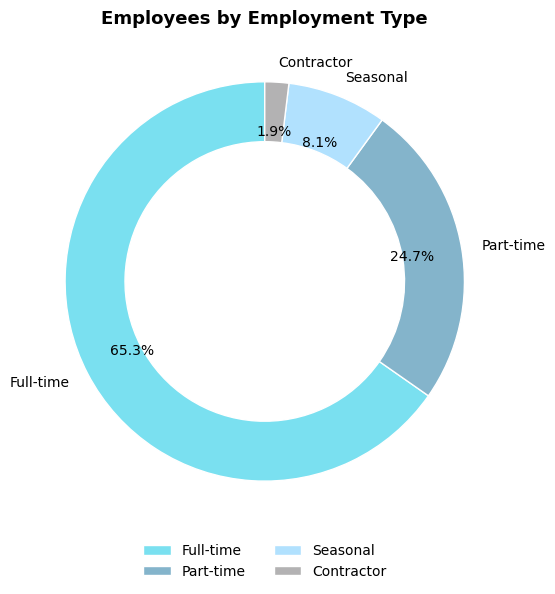

In [28]:
col = next((c for c in emp.columns if 'employment' in c.lower() and 'type' in c.lower()), None)
if col:
    s = emp[col].fillna('Unknown').value_counts()
    draw_donut(s, 'Employees by Employment Type', colors=[COLORS['accent1'], COLORS['accent2'], COLORS['accent3'], COLORS['muted']], outname='v01_employment_type.png')
else:
    print('Employment Type column not found.')

###### Visual 2 — Managers by Status

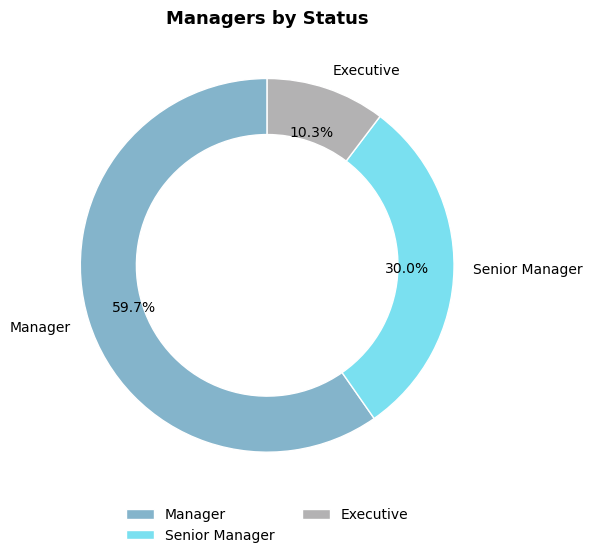

In [29]:
col = next((c for c in emp.columns if 'manager' in c.lower() and 'status' in c.lower()), None)
if col:
    s = emp[col].fillna('Unknown').value_counts()
    draw_donut(s, 'Managers by Status', colors=[COLORS['accent2'], COLORS['accent1'], COLORS['muted']], outname='v02_managers_status.png')
else:
    jt = next((c for c in emp.columns if 'title' in c.lower()), None)
    if jt:
        s = emp[jt].fillna('').str.contains('Manager', na=False).map({True:'Manager', False:'Non-Manager'}).value_counts()
        draw_donut(s, 'Managers by Job Title', colors=[COLORS['accent1'], COLORS['muted']], outname='v02_managers_status_title.png')
    else:
        print('Managers column not found.')

###### Visual 3 — Employees by Salary Band

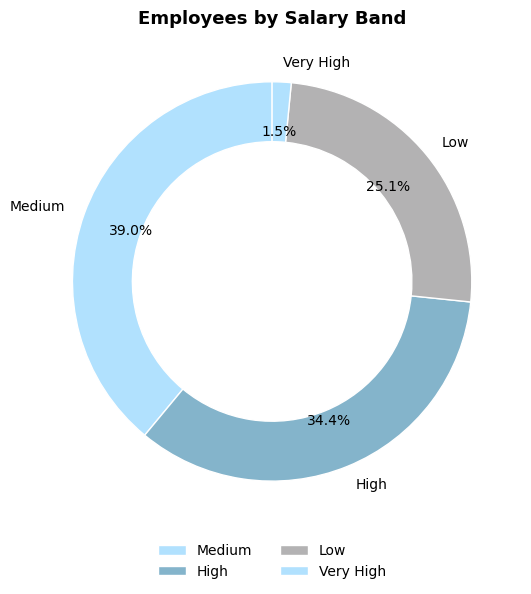

In [30]:
col = next((c for c in emp.columns if 'salary band' in c.lower() or 'salary_band' in c.lower() or 'salaryband' in c.lower()), None)
if col:
    s = emp[col].fillna('Unknown').value_counts()
    draw_donut(s, 'Employees by Salary Band', colors=[COLORS['accent3'], COLORS['accent2'], COLORS['muted']], outname='v03_salary_band.png')
else:
    # fallback: create salary bands if salary exists
    sal = next((c for c in emp.columns if 'salary' in c.lower()), None)
    if sal:
        bins = [0,200000,400000,600000,800000,1e9]
        labels = ['<200k','200-400k','400-600k','600-800k','800k+']
        s = pd.cut(emp[sal].fillna(0), bins=bins, labels=labels).value_counts()
        draw_donut(s, 'Employees by Salary Band (derived)', colors=[COLORS['accent3'], COLORS['accent2'], COLORS['muted']], outname='v03_salary_band_derived.png')
    else:
        print('Salary band or salary column not found.')

###### Visual 4 — Employee Distribution by Age Group & Gender (percent)

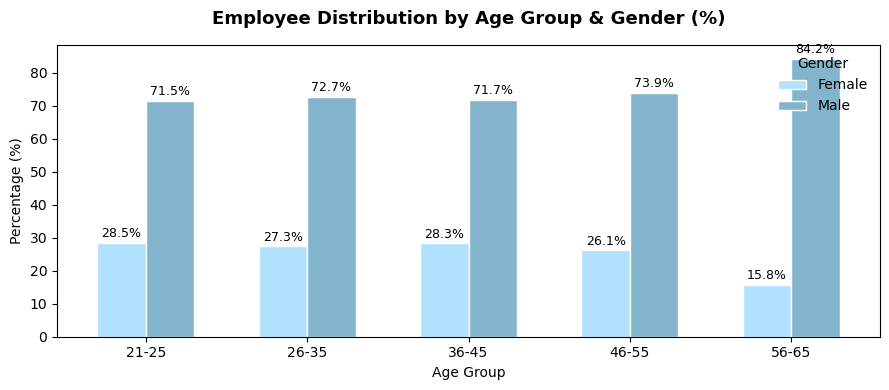

In [31]:
# Visual 4 — Employee Distribution by Age Group & Gender (%)

gender_col = next((c for c in emp.columns if 'gender' in c.lower()), None)

if 'Age Group' in emp.columns and gender_col:
    df = emp.groupby(['Age Group', gender_col]).size().unstack(fill_value=0)
    df_pct = df.div(df.sum(axis=1), axis=0) * 100

    fig, ax = plt.subplots(figsize=(9, 4))
    df_pct.plot(kind='bar', ax=ax, width=0.6,
                color=[COLORS['accent3'], COLORS['accent2']],
                edgecolor='white')

    # Add data labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', label_type='edge', fontsize=9, padding=2)

    # Styling
    ax.set_title('Employee Distribution by Age Group & Gender (%)', fontsize=13, fontweight='bold', pad=15)
    ax.set_xlabel('Age Group', fontsize=10)
    ax.set_ylabel('Percentage (%)', fontsize=10)
    ax.set_facecolor('white')
    plt.xticks(rotation=0)
    plt.legend(title='Gender', loc='upper right', frameon=False)
    plt.tight_layout()
    plt.savefig(OUT_FOLDER / 'v04_age_gender_pct.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print('Age Group or Gender column missing.')


###### Visual 5 — Employee Distribution by Department & Gender (percent)

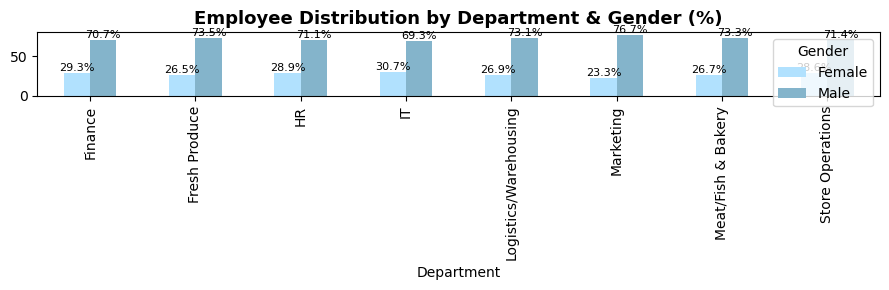

In [32]:
dept_col = next((c for c in emp.columns if 'department' in c.lower()), None)
gender_col = next((c for c in emp.columns if 'gender' in c.lower()), None)
if dept_col and gender_col:
    top = emp[dept_col].value_counts().nlargest(8).index.tolist()
    df = emp[emp[dept_col].isin(top)].groupby([dept_col, gender_col]).size().unstack(fill_value=0)
    df_pct = df.div(df.sum(axis=1), axis=0) * 100
    df_pct.plot(kind='bar', figsize=(9,3), color=[COLORS['accent3'], COLORS['accent2']])
    plt.title('Employee Distribution by Department & Gender (%)', fontsize=13, fontweight='bold')
    for p in plt.gca().patches:
        h = p.get_height()
        if h>0:
            plt.gca().annotate(f"{h:.1f}%", (p.get_x()+p.get_width()/2, p.get_y()+h), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(OUT_FOLDER/'v05_dept_gender_pct.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print('Department or Gender column missing.')

###### Visual 6 — Employee Distribution by Educational Level & Gender (percent)

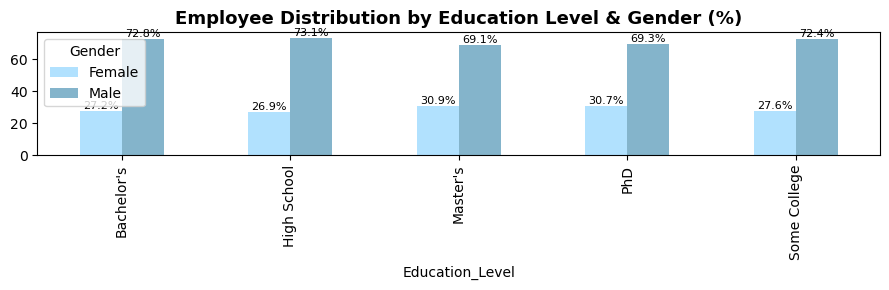

In [33]:
edu_col = next((c for c in emp.columns if 'educ' in c.lower() or 'education' in c.lower()), None)
gender_col = next((c for c in emp.columns if 'gender' in c.lower()), None)
if edu_col and gender_col:
    df = emp.groupby([edu_col, gender_col]).size().unstack(fill_value=0)
    df_pct = df.div(df.sum(axis=1), axis=0) * 100
    df_pct.plot(kind='bar', figsize=(9,3), color=[COLORS['accent3'], COLORS['accent2']])
    plt.title('Employee Distribution by Education Level & Gender (%)', fontsize=13, fontweight='bold')
    for p in plt.gca().patches:
        h = p.get_height()
        if h>0:
            plt.gca().annotate(f"{h:.1f}%", (p.get_x()+p.get_width()/2, p.get_y()+h), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(OUT_FOLDER/'v06_edu_gender_pct.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print('Education or Gender column missing.')

###### Visual 7 — Employee Distribution by Job Level & Gender (percent)

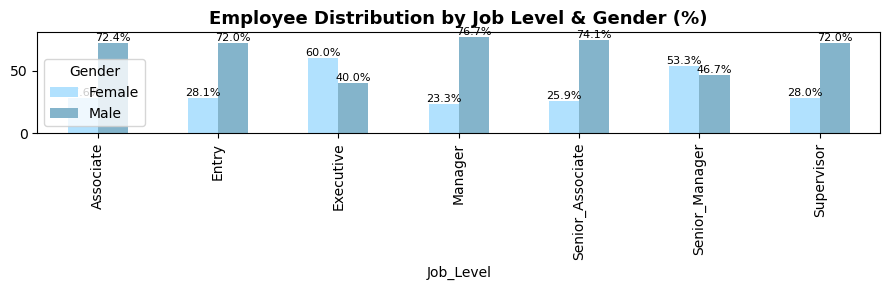

In [34]:
job_col = next((c for c in emp.columns if 'job level' in c.lower() or 'job_level' in c.lower() or ('job' in c.lower() and 'level' in c.lower())), None)
gender_col = next((c for c in emp.columns if 'gender' in c.lower()), None)
if job_col is None:
    job_col = next((c for c in emp.columns if 'job' in c.lower()), None)
if job_col and gender_col:
    df = emp.groupby([job_col, gender_col]).size().unstack(fill_value=0)
    df_pct = df.div(df.sum(axis=1), axis=0) * 100
    df_pct.plot(kind='bar', figsize=(9,3), color=[COLORS['accent3'], COLORS['accent2']])
    plt.title('Employee Distribution by Job Level & Gender (%)', fontsize=13, fontweight='bold')
    for p in plt.gca().patches:
        h = p.get_height()
        if h>0:
            plt.gca().annotate(f"{h:.1f}%", (p.get_x()+p.get_width()/2, p.get_y()+h), ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.savefig(OUT_FOLDER/'v07_job_gender_pct.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print('Job Level or Gender column missing.')

###### Visual 8 — Yearly Employee Headcount Trend

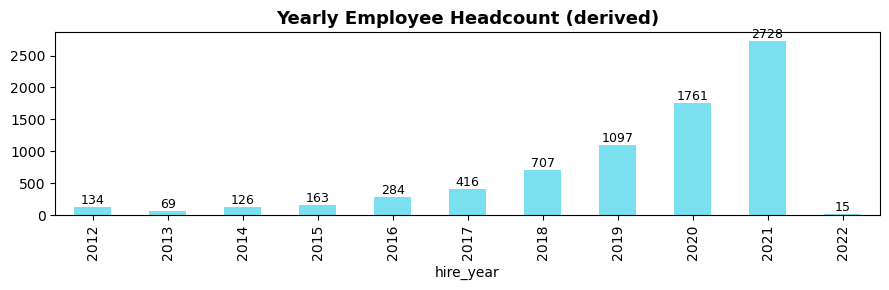

In [35]:
# try to find year/count in dim else derive from hire date
year_col = next((c for c in dim.columns if 'year' in c.lower()), None)
count_col = next((c for c in dim.columns if 'headcount' in c.lower() or 'count' in c.lower()), None)
if year_col and count_col:
    s = dim.groupby(year_col)[count_col].sum().sort_index()
    fig, ax = plt.subplots(figsize=(9,3))
    s.plot(kind='bar', ax=ax, color=COLORS['accent1'])
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom', fontsize=9)
    plt.title('Yearly Employee Headcount', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUT_FOLDER/'v08_headcount_trend.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    hire_col = next((c for c in emp.columns if 'hire' in c.lower() and 'date' in c.lower()), None)
    if hire_col:
        emp['hire_year'] = pd.to_datetime(emp[hire_col], errors='coerce').dt.year
        s = emp.groupby('hire_year').size().sort_index()
        fig, ax = plt.subplots(figsize=(9,3))
        s.plot(kind='bar', ax=ax, color=COLORS['accent1'])
        for p in ax.patches:
            ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom', fontsize=9)
        plt.title('Yearly Employee Headcount (derived)', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.savefig(OUT_FOLDER/'v08_headcount_trend_derived.png', bbox_inches='tight', facecolor='white')
        plt.show()
    else:
        print('Headcount data not found.')

###### Visual 9 — Yearly Active Employee Trend

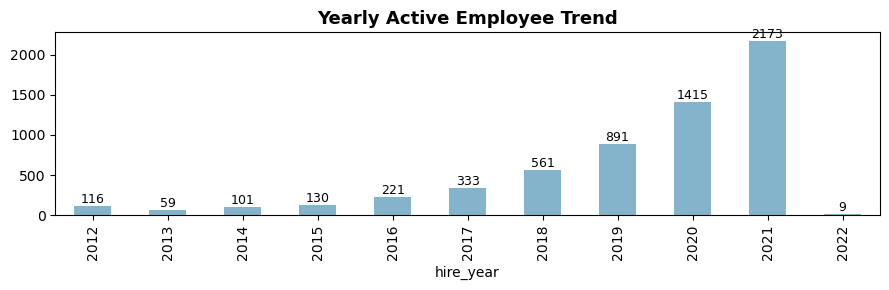

In [36]:
hire_col = next((c for c in emp.columns if 'hire' in c.lower() and 'date' in c.lower()), None)
status_col = next((c for c in emp.columns if 'staus' in c.lower() or 'status' in c.lower()), None)
if hire_col and status_col:
    emp['hire_year'] = pd.to_datetime(emp[hire_col], errors='coerce').dt.year
    active = emp[emp[status_col].astype(str).str.lower()=='active']
    s = active.groupby('hire_year').size().sort_index()
    fig, ax = plt.subplots(figsize=(9,3))
    s.plot(kind='bar', ax=ax, color=COLORS['accent2'])
    for p in ax.patches:
        ax.annotate(int(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom', fontsize=9)
    plt.title('Yearly Active Employee Trend', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUT_FOLDER/'v09_active_trend.png', bbox_inches='tight', facecolor='white')
    plt.show()
else:
    print('Hire date or Status column missing.')

###### Visual 11 — Employee Projection by Job Level

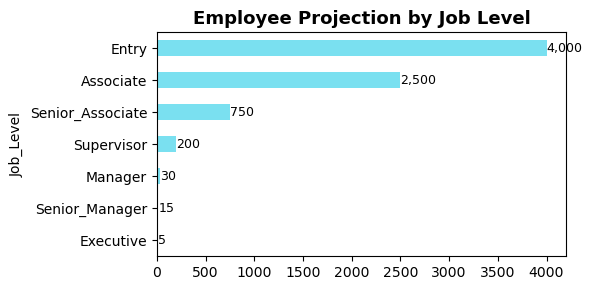

In [37]:
job_col = next((c for c in emp.columns if 'job level' in c.lower() or 'job_level' in c.lower()), None)
if job_col is None:
    job_col = next((c for c in emp.columns if 'job' in c.lower()), None)
if job_col:
    s = emp[job_col].fillna('Unknown').value_counts().sort_values(ascending=True)
    draw_horizontal_bars(s, 'Employee Projection by Job Level', outname='v11_job_level.png')
else:
    print('Job Level column missing.')

###### Visual 16 — Employees by Rating Category

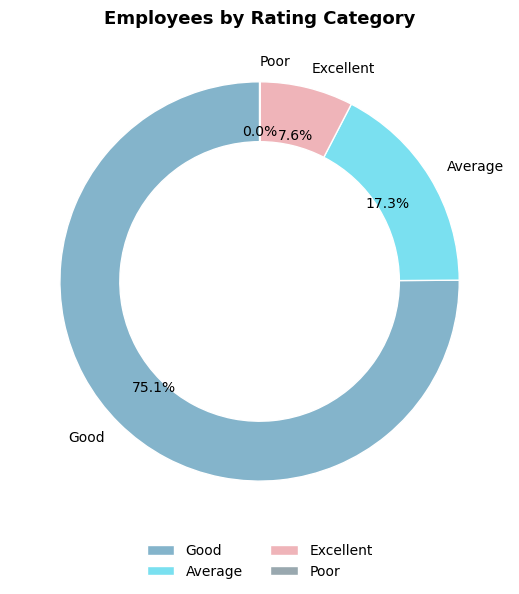

In [38]:
rating_col = next((c for c in dim.columns if 'rating_category' in c.lower() or 'rating category' in c.lower() or 'rating'==c.lower()), None)
if rating_col:
    s = dim[rating_col].fillna('Unknown').value_counts()
    draw_donut(s, 'Employees by Rating Category', colors=[COLORS['excellent'], COLORS['good'], COLORS['average'], COLORS['poor']], outname='v16_rating.png')
else:
    print('Rating column not found in dim.')

###### Visual 17 — Employees by Satisfaction Category

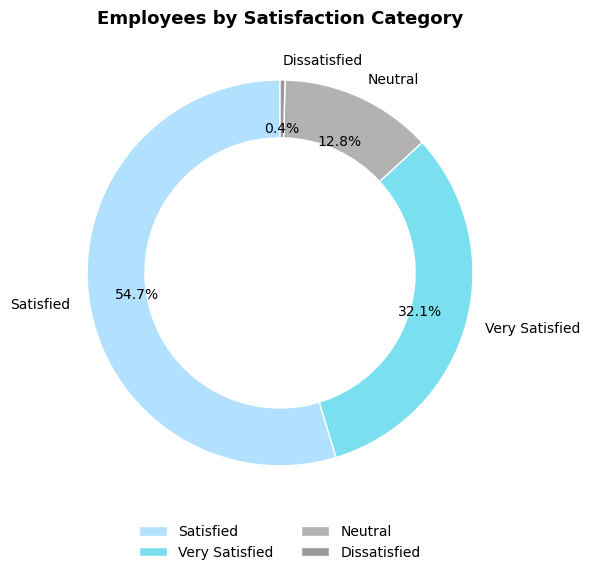

In [39]:
satisf_col = next((c for c in dim.columns if 'satisfaction_category' in c.lower() or 'satisfaction category' in c.lower() or 'satisfaction' == c.lower()), None)
if satisf_col:
    s = dim[satisf_col].fillna('Unknown').value_counts()
    draw_donut(s, 'Employees by Satisfaction Category', colors=[COLORS['accent3'], COLORS['accent1'], COLORS['muted'], '#999999'], outname='v17_satisfaction.png')
else:
    print('Satisfaction column not found in dim.')

###### Visual 18 — Employees by Evaluation Category

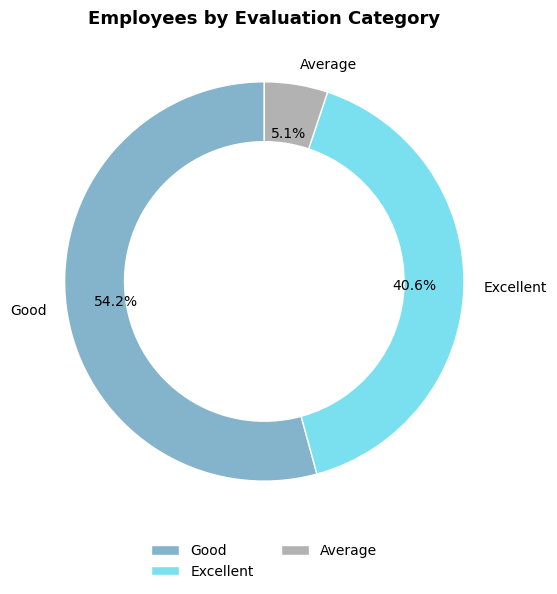

In [40]:
eval_col = next((c for c in dim.columns if 'evaluation_category' in c.lower() or 'evaluation category' in c.lower() or 'evaluation' == c.lower()), None)
if eval_col:
    s = dim[eval_col].fillna('Unknown').value_counts()
    draw_donut(s, 'Employees by Evaluation Category', colors=[COLORS['accent2'], COLORS['accent1'], COLORS['muted'], '#CCCCCC'], outname='v18_evaluation.png')
else:
    print('Evaluation column not found in dim.')